In [1]:
# public libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc

In [2]:
import tensorflow as tf
import numpy as np
from tensorflow import keras

%load_ext tensorboard

2024-01-09 10:56:49.553230: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-09 10:56:49.697503: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-09 10:56:50.328396: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-01-09 10:56:50.328504: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

## retrieve data

In [3]:
# we'll read both of these values and the original input and irrelevant tcrs
cdr3_to_X = pd.read_csv('../outputs/model_v3/cdr3.conversion.n30.csv', index_col=0)
ag_to_X = pd.read_csv('../outputs/model_v3/epitope.conversion.n15.csv', index_col=0)

# read in validation data
hit_val = pd.read_csv('../outputs/model_v5/validation.pos.csv', index_col=0)
irr_val = pd.read_csv('../outputs/model_v5/validation.neg.csv', index_col=0)

# create X for validation
X_val = pd.concat([hit_val, irr_val], axis=0).reset_index().iloc[:, 1:]
X_val_cdr3s = cdr3_to_X.loc[X_val['CDR3']].reset_index().iloc[:, 1:]
X_val_epitopes = ag_to_X.loc[X_val['Epitope']].reset_index().iloc[:, 1:]
# combine
X_val_cdr3s.columns = 'cdr3:' + X_val_cdr3s.columns
X_val_epitopes.columns = 'ag:' + X_val_epitopes.columns
X_val = X_val_cdr3s.join(X_val_epitopes)

# grab y for validation
y_val = pd.concat([pd.Series(np.ones(hit_val.shape[0])),
                     pd.Series(np.zeros(irr_val.shape[0]))], axis=0).astype(int)
y_val = y_val.reset_index().iloc[:, 1:][0]

# confirm the same length
assert X_val.shape[0] == y_val.shape[0]

# read in normalization factors
means = pd.read_csv('../outputs/model_v5/model_v5.means.csv', index_col=0).iloc[:, 0]
stds = pd.read_csv('../outputs/model_v5/model_v5.stds.csv', index_col=0).iloc[:, 0]
# subset for relevant columns
X_val = X_val[means.index]
# normalize
X_val -= means
X_val /= stds

In [4]:
# load in the model
model = keras.models.load_model('../outputs/model_v5/model_v5.r1.keras')

# gather cdr3s and epitopes for future work
cdr3s = pd.concat([hit_val, irr_val], axis=0).reset_index().iloc[:, 1:]['CDR3']
epitopes = pd.concat([hit_val, irr_val], axis=0).reset_index().iloc[:, 1:]['Epitope']

2024-01-09 10:57:00.879884: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2024-01-09 10:57:00.879933: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-01-09 10:57:00.880398: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# subset test dataset for this antigen
antigen = 'GILGFVFTL'
X_val = X_val.loc[(epitopes == antigen).values]

In [9]:
from anndata import AnnData
# create anndata object for dimension reduction
adata = AnnData(X_val)

# retrieve the appropriate columns
cols_cdr3 = X_val.columns[X_val.columns.str.startswith('cdr3')]
cols_ag = X_val.columns[X_val.columns.str.startswith('ag')]
# compute out embedding from the model (green layer)
out_cdr3 = model.layers[2](model.layers[0](X_val[cols_cdr3].astype(float).values))
out_ag = model.layers[3](model.layers[1](X_val[cols_ag].astype(float).values))
out_cdr3ag = model.layers[5](model.layers[4]([out_cdr3, out_ag]))
# add embedding to anndata object
adata.obsm['X_cdr3ag'] = out_cdr3ag.numpy()

# compute the typical dimension reductions
np.random.seed(0)
sc.pp.neighbors(adata, n_neighbors=30, use_rep='X_cdr3ag', n_pcs=adata.obsm['X_cdr3ag'].shape[1])
sc.tl.umap(adata, random_state=0)

# add in the observations
adata.obs['CDR3'] = cdr3s.loc[(epitopes == antigen).values]
adata.obs['Epitope'] = epitopes.loc[(epitopes == antigen).values]

# fix plotting beautifulness
sc.settings.set_figure_params(dpi=100)

/tmp/ipykernel_24621/3579403412.py:3: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = AnnData(X_val)
/home/dchen/anaconda3/envs/base_py38/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


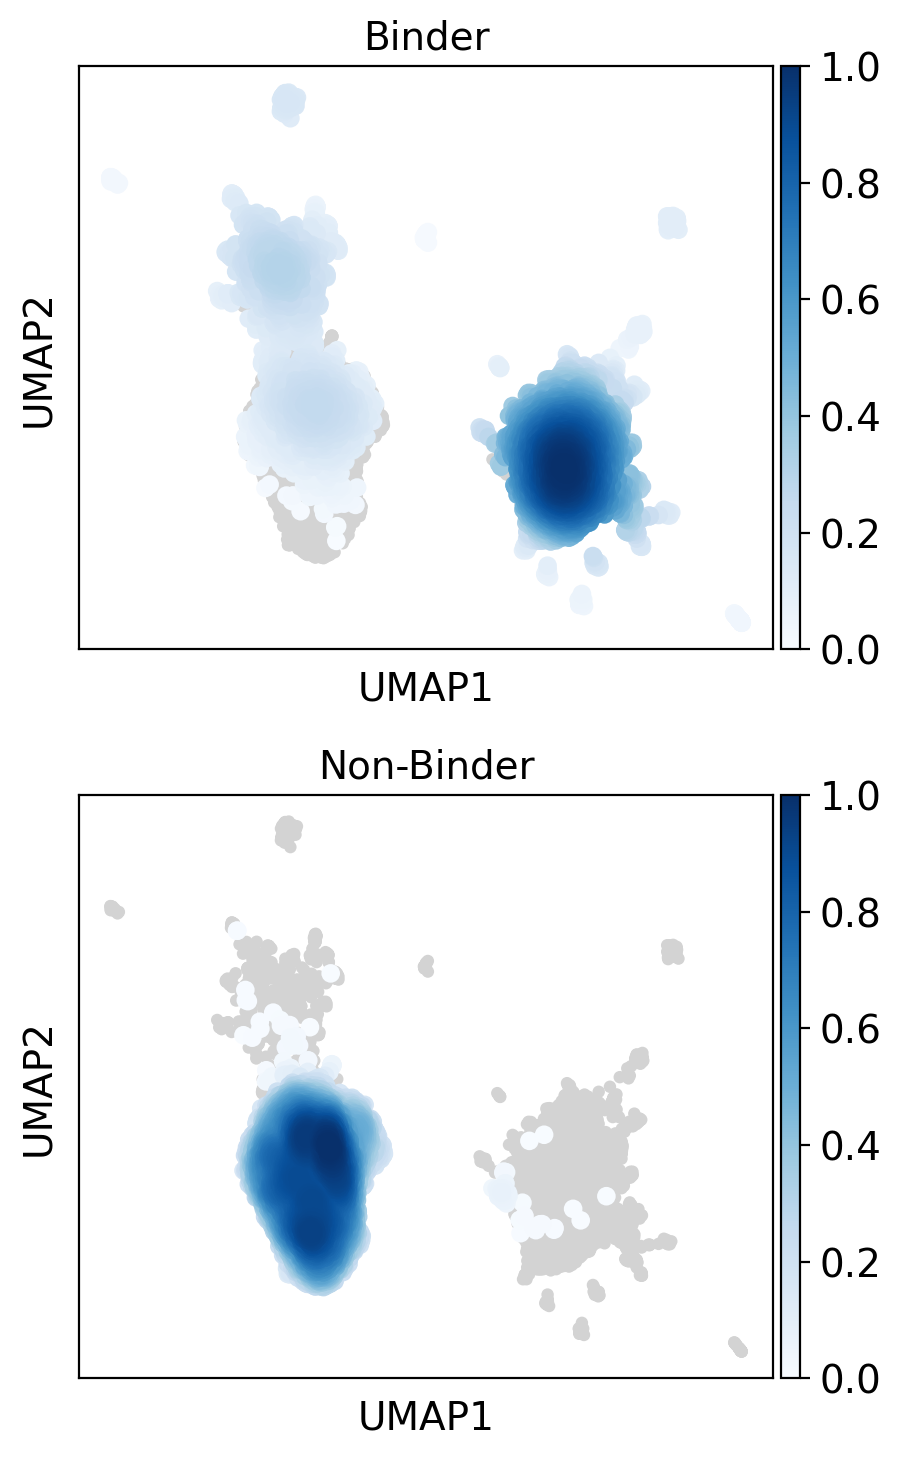

In [10]:
# plot the UMAP
adata.obs['Match'] = y_val[(epitopes == antigen).values].values
adata.obs['Match'] = pd.Categorical(adata.obs['Match'].map({0:'Non-Binder', 1:'Binder'}))
sc.tl.embedding_density(adata, groupby='Match')
sc.pl.embedding_density(adata, key='umap_density_Match', ncols=1, color_map='Blues')

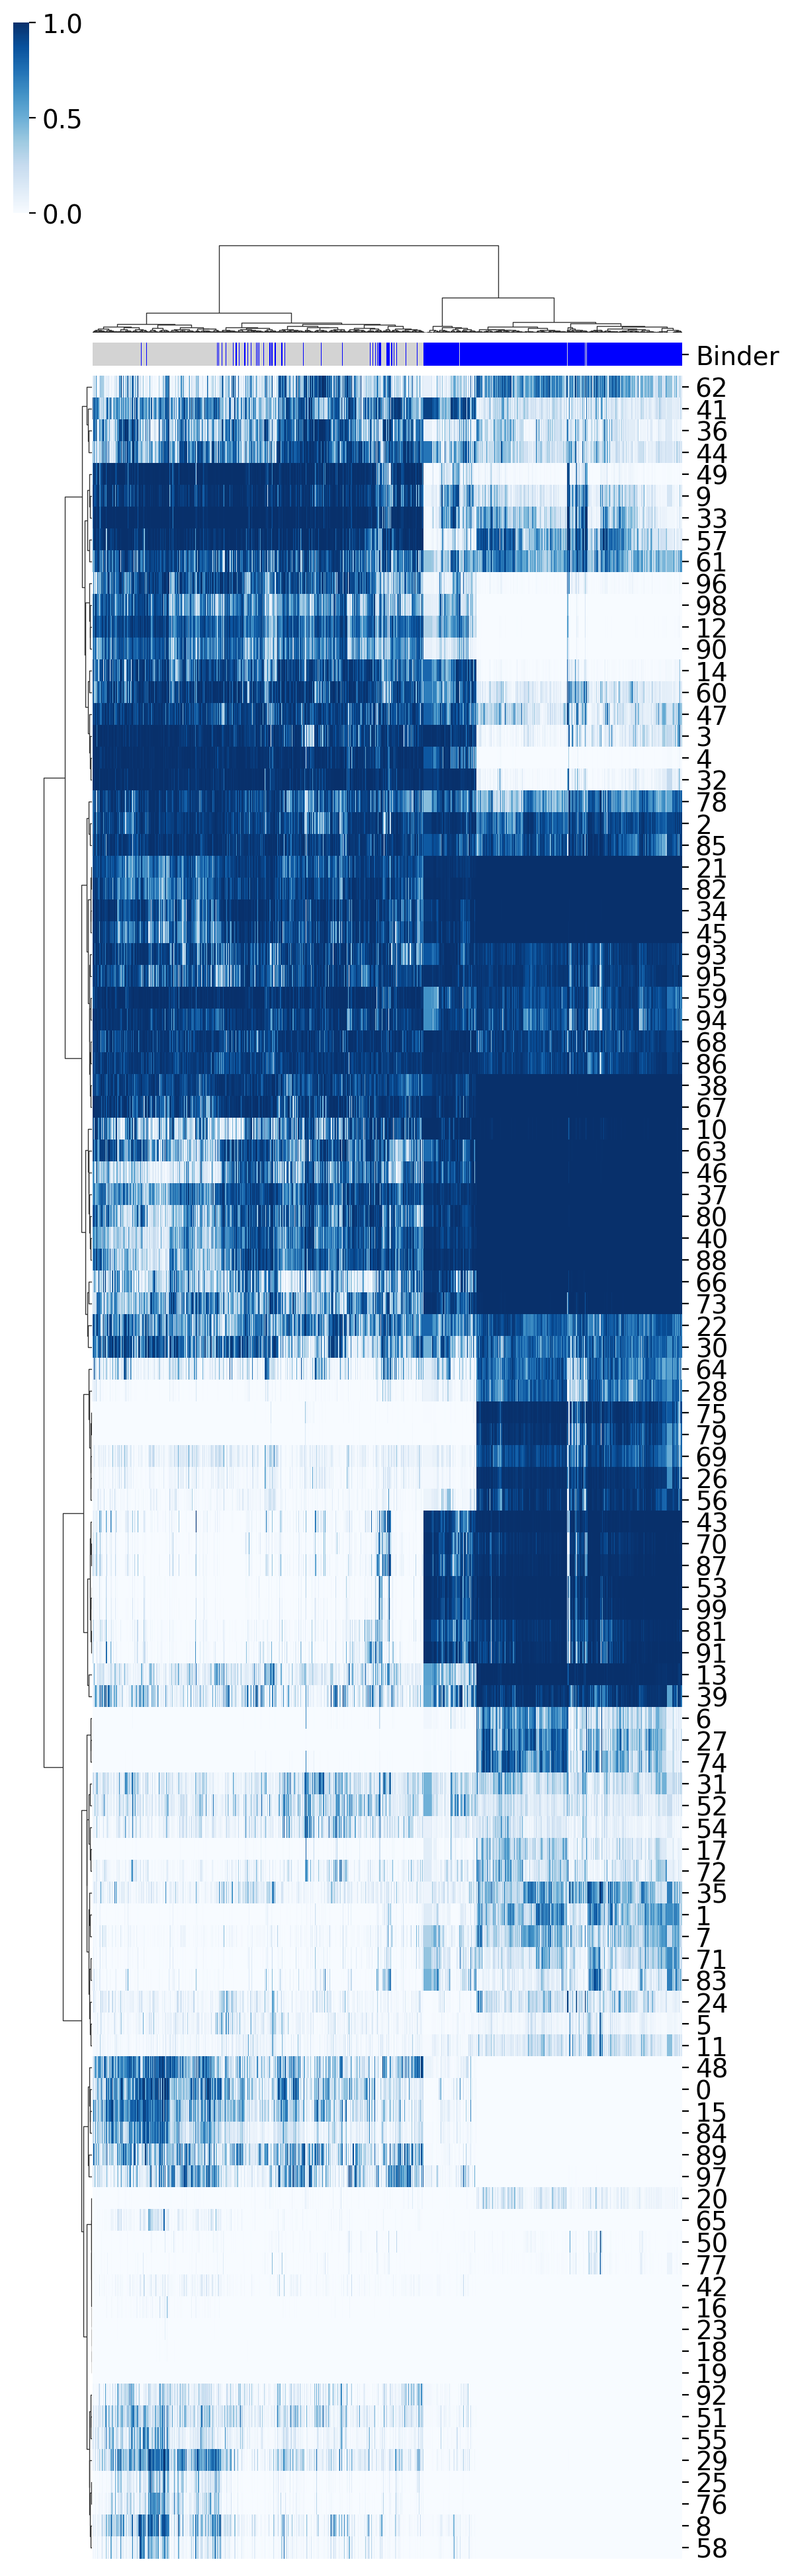

In [11]:
# determine which rulesets are most differential
plot = pd.DataFrame(adata.obsm['X_cdr3ag'])
pal_match = {adata.obs['Match'].cat.categories.tolist()[idx]: col for idx, col in enumerate(['b','lightgray'])}
row_colors = adata.obs['Match'].map(pal_match).reset_index().iloc[:, 1:]
row_colors.columns = ['Binder']

g = sns.clustermap(plot.T, col_colors=row_colors, method='ward', figsize=[6, 18],
                   xticklabels=0, yticklabels=1, colors_ratio=.01, dendrogram_ratio=(.08, .04),
                   cbar_pos=(0, 1, .02, .08), cmap='Blues')

In [69]:
import scipy.stats as ss
# loop through each ruleset
order = [x.get_text() for x in g.ax_heatmap.get_yticklabels()]
mask_binder = row_colors['Binder'] == 'b'
pvalues = pd.Series()
diffs = pd.Series()
# loop through the columns
for col in order:
    p = ss.mannwhitneyu(plot.loc[mask_binder, int(col)], plot.loc[~mask_binder, int(col)])[1]
    pvalues.loc[col] = p
    diffs.loc[col] = plot.loc[mask_binder, int(col)].mean() - plot.loc[~mask_binder, int(col)].mean()
    
from statsmodels.stats.multitest import fdrcorrection
# get multiple hypothesis correction
_, fdrs = fdrcorrection(pvalues)
fdrs = pd.Series(fdrs, index=pvalues.index)
# now supplement
fdrs[fdrs == 0] = fdrs[fdrs > 0].min()

(-1.0, 100.0)

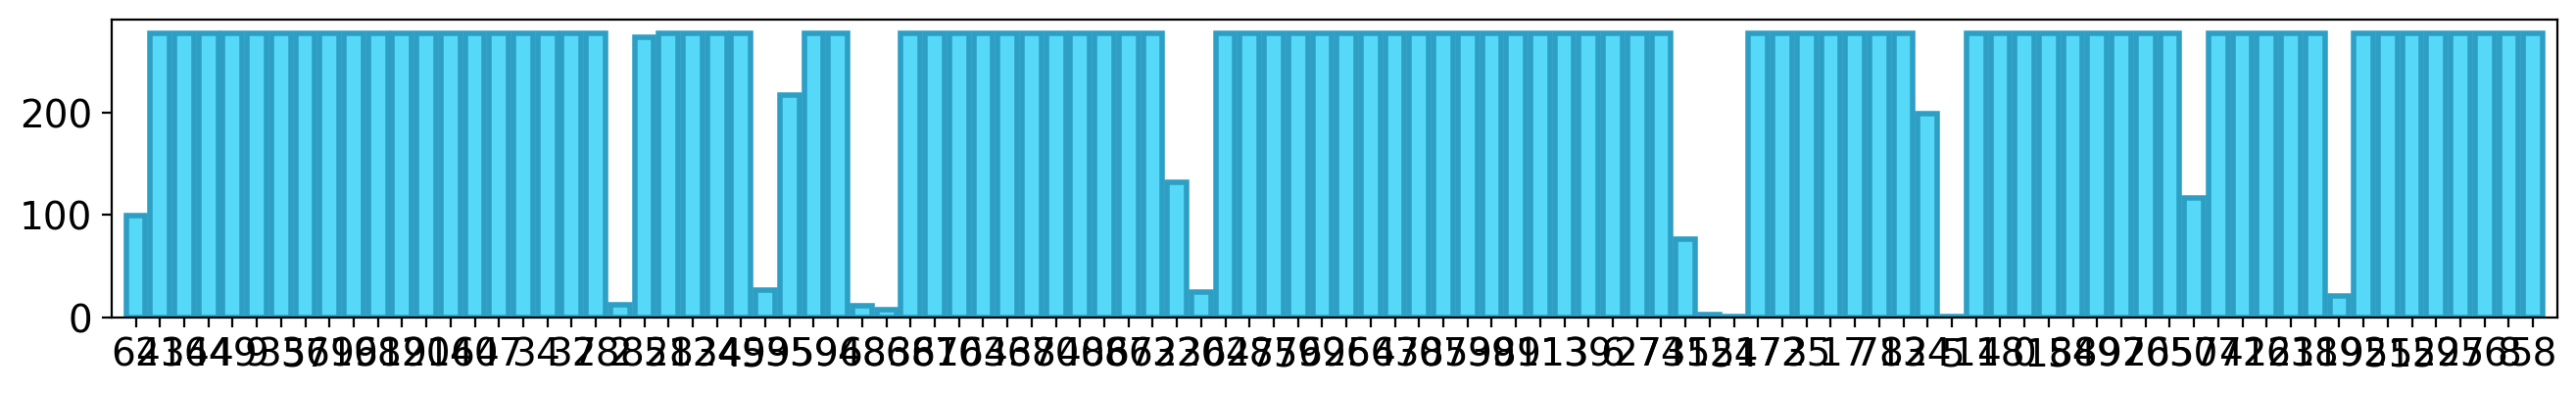

In [70]:
# plot pvalues
fig, ax = plt.subplots(figsize=[16, 2])
ax.grid(False)
ax.bar(fdrs.index, -np.log10(fdrs), color='#56D8F8', edgecolor='#2D9FC4', linewidth=2)
ax.set_xlim(-1, pvalues.shape[0])

In [71]:
# find the top differential
diffs[fdrs == fdrs.min()].sort_values()

49   -0.779935
4    -0.700099
32   -0.635648
12   -0.625381
96   -0.623396
        ...   
43    0.786290
87    0.789182
70    0.798752
99    0.821049
53    0.829501
Length: 84, dtype: float32

In [15]:
def consider_value(value):
    # grab the cdr3 nodes for significantly weighted negative nodes
    cdr3_cols = weights.index[:10]
    cdr3_weights = pd.DataFrame(model.layers[2].kernel.numpy()[:, cdr3_cols], index=cols_cdr3)
    cdr3_weights.index = cdr3_weights.index.str.slice(5)
    cdr3_weights.columns = cdr3_cols
    cdr3_neg = (cdr3_weights.loc[cdr3_weights.index.str.endswith(value)] * abs(weights[:10])).mean(1)
    cdr3_neg.index = cdr3_neg.index.str.replace(value,'').astype(int)
    # grab the cdr3 nodes for significantly weighted positive nodes
    cdr3_cols = weights.index[-10:]
    cdr3_weights = pd.DataFrame(model.layers[2].kernel.numpy()[:, cdr3_cols], index=cols_cdr3)
    cdr3_weights.index = cdr3_weights.index.str.slice(5)
    cdr3_weights.columns = cdr3_cols
    cdr3_pos = (cdr3_weights.loc[cdr3_weights.index.str.endswith(value)] * abs(weights[-10:])).mean(1)
    cdr3_pos.index = cdr3_pos.index.str.replace(value,'').astype(int)

    # plot a few interesting metrics
    fig, ax = plt.subplots(figsize=[4, 4])
    ax.grid(False)
    ax.plot(cdr3_neg.index, cdr3_neg, color='b', linestyle='--')
    ax.plot(cdr3_pos.index, cdr3_pos, color='b')
    ax.set(xlabel='Position', ylabel=value.title())
    ax.plot([-1, 31], [0, 0], color='k')
    ax.set_xlim(-1, 31)
    
    # plot a few interesting metrics
    fig, ax = plt.subplots(figsize=[4, 4])
    ax.grid(False)
    ax.plot(cdr3_neg.index, cdr3_pos - cdr3_neg, color='b')
    ax.set(xlabel='Position', ylabel=value.title())
    ax.plot([-1, 31], [0, 0], color='k')
    ax.set_xlim(-1, 31)

/tmp/ipykernel_24621/2603696404.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=xs, y=ys, errorbar=('ci', 95), err_kws={'linewidth': 2}, capsize=0.3,
/tmp/ipykernel_24621/2603696404.py:7: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'k'}` instead.

  sns.barplot(x=xs, y=ys, errorbar=('ci', 95), err_kws={'linewidth': 2}, capsize=0.3,


49 0.0


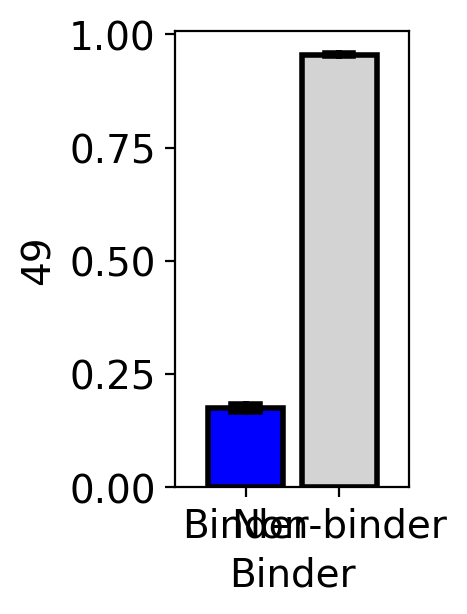

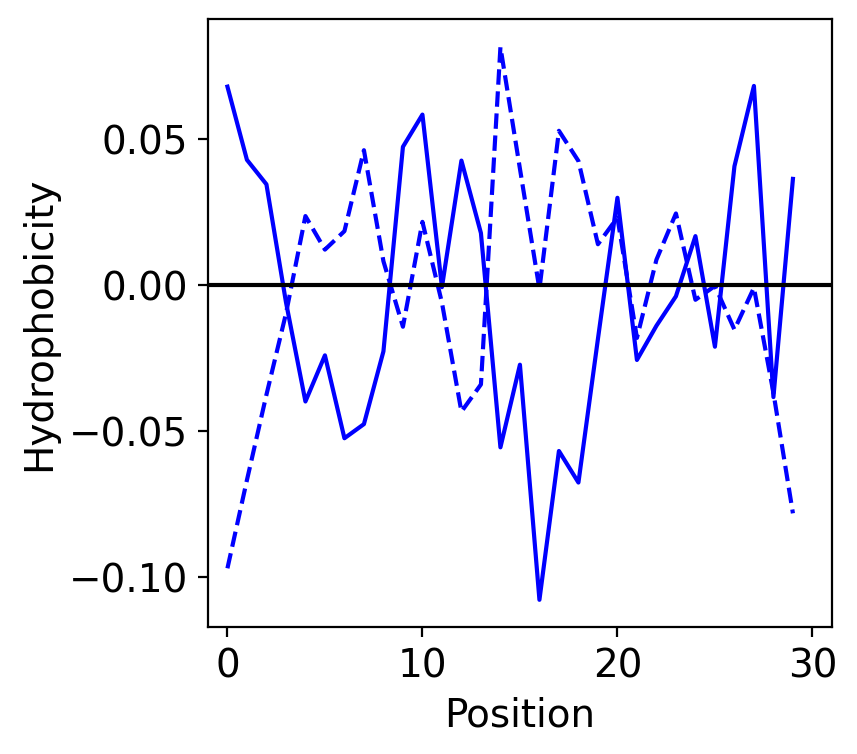

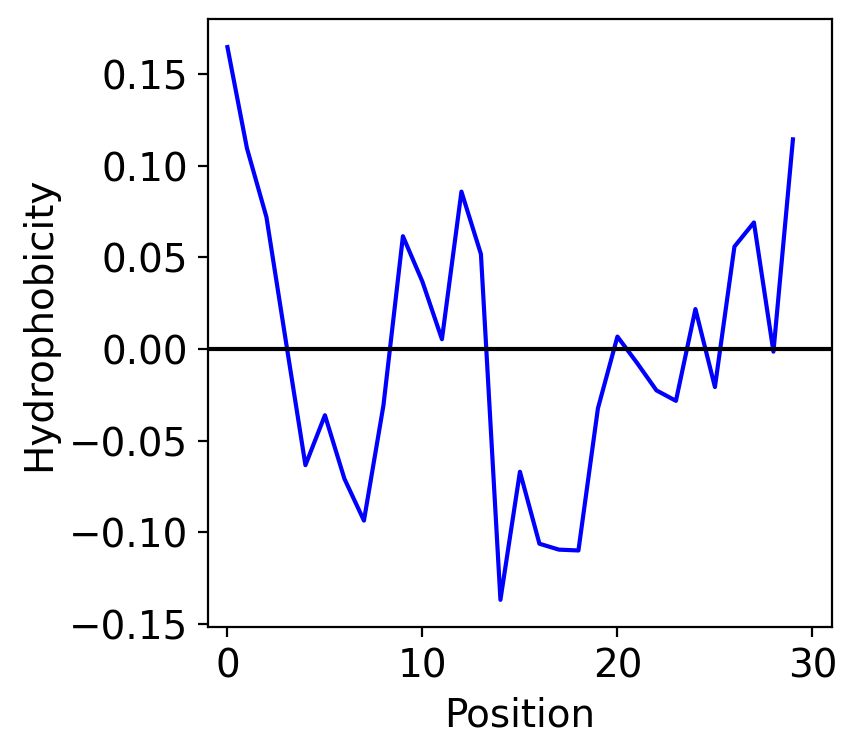

In [40]:
# for the most significant one check the pvalue and distribution
best = '49'
xs = row_colors['Binder'].map({'b':'Binder', 'lightgray':'Non-binder'})
ys = plot[int(best)]
fig, ax = plt.subplots(figsize=[1.5, 3])
ax.grid(False)
sns.barplot(x=xs, y=ys, errorbar=('ci', 95), err_kws={'linewidth': 2}, capsize=0.3,
            saturation=1, palette=['b','lightgray'], edgecolor='k', errcolor='k', linewidth=2)
ax.set_xlim(-0.75, 1.75)
print(best, ss.mannwhitneyu(ys[xs == 'Binder'], ys[xs != 'Binder'])[1])

# weights that are most important for the given node
weights = pd.Series(model.layers[5].kernel.numpy()[:200, int(best)]).sort_values()

# plot the features
consider_value('hydrophobicity')

/tmp/ipykernel_24621/4131556124.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=xs, y=ys, errorbar=('ci', 95), err_kws={'linewidth': 2}, capsize=0.3,
/tmp/ipykernel_24621/4131556124.py:7: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'k'}` instead.

  sns.barplot(x=xs, y=ys, errorbar=('ci', 95), err_kws={'linewidth': 2}, capsize=0.3,


53 0.0


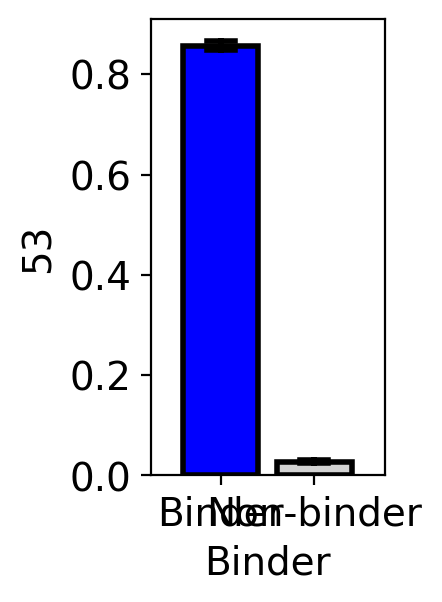

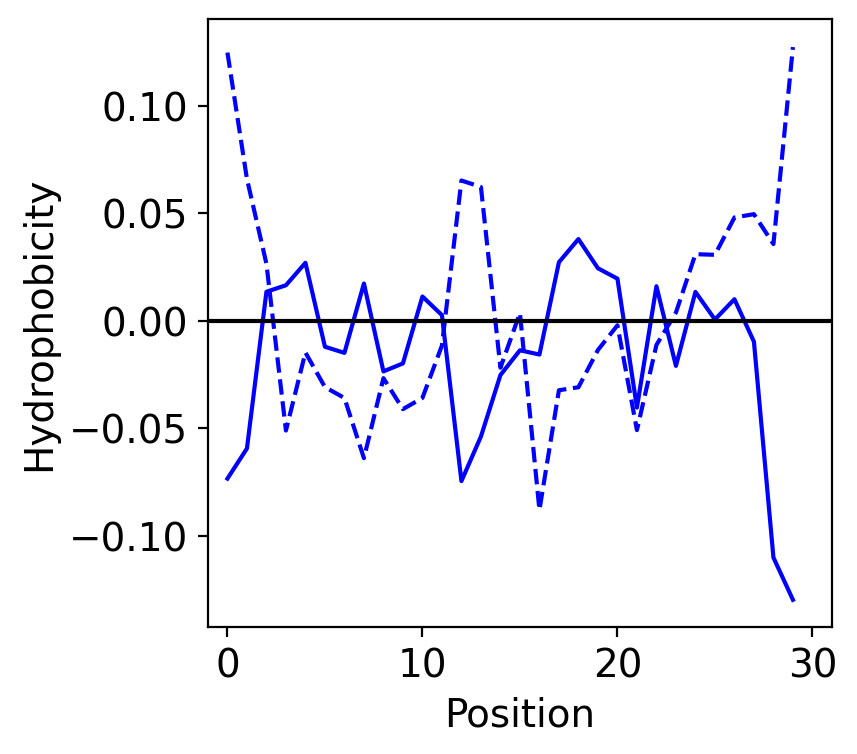

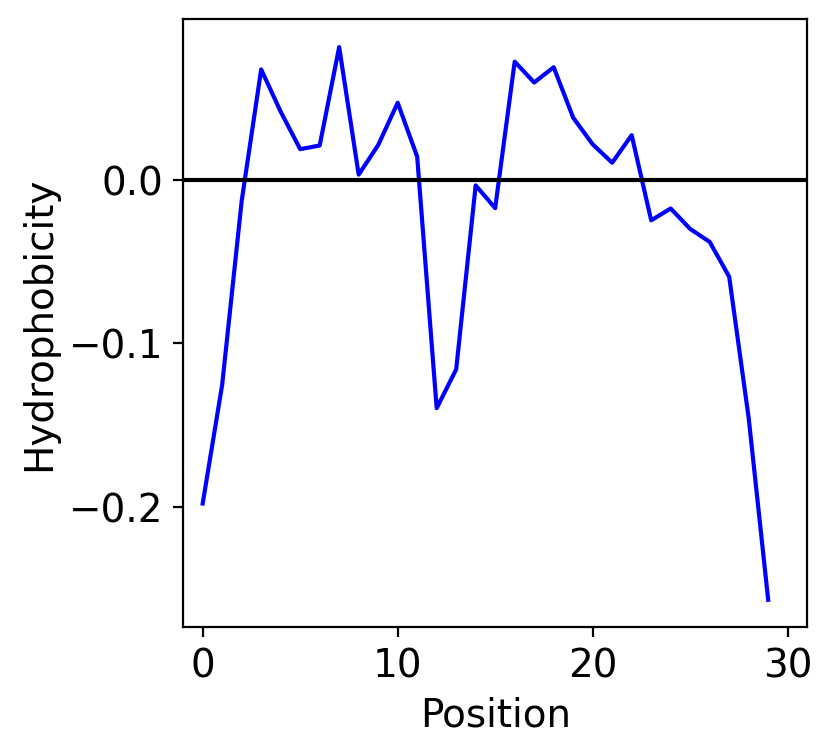

In [67]:
# for the most significant one check the pvalue and distribution
best = '53'
xs = row_colors['Binder'].map({'b':'Binder', 'lightgray':'Non-binder'})
ys = plot[int(best)]
fig, ax = plt.subplots(figsize=[1.5, 3])
ax.grid(False)
sns.barplot(x=xs, y=ys, errorbar=('ci', 95), err_kws={'linewidth': 2}, capsize=0.3,
            saturation=1, palette=['b','lightgray'], edgecolor='k', errcolor='k', linewidth=2)
ax.set_xlim(-0.75, 1.75)
print(best, ss.mannwhitneyu(ys[xs == 'Binder'], ys[xs != 'Binder'])[1])

# weights that are most important for the given node
weights = pd.Series(model.layers[5].kernel.numpy()[:200, int(best)]).sort_values()

# plot the features
consider_value('hydrophobicity')

/tmp/ipykernel_24621/3740185176.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=xs, y=ys, errorbar=('ci', 95), err_kws={'linewidth': 2}, capsize=0.3,
/tmp/ipykernel_24621/3740185176.py:8: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'k'}` instead.

  sns.barplot(x=xs, y=ys, errorbar=('ci', 95), err_kws={'linewidth': 2}, capsize=0.3,


87 0.0


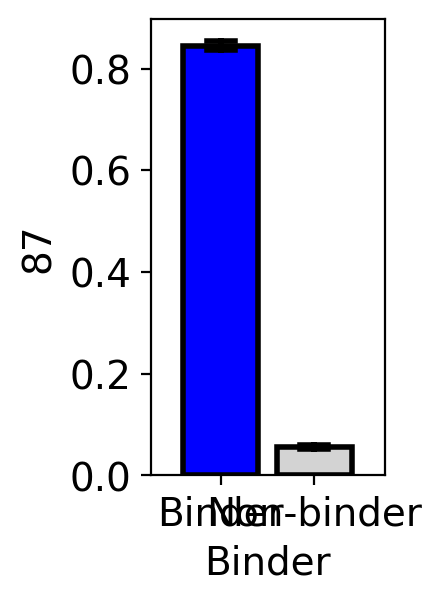

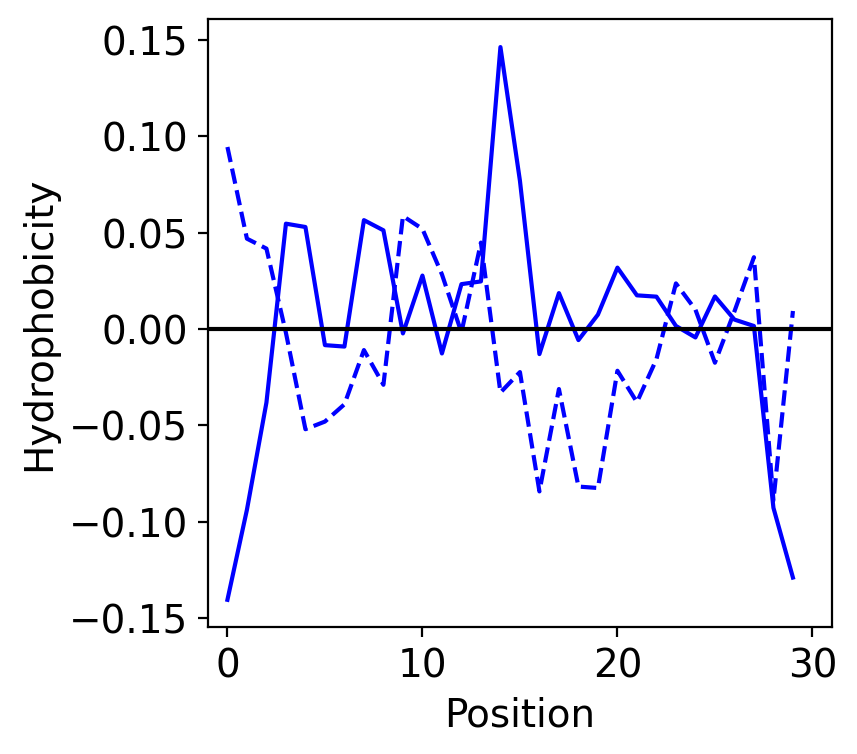

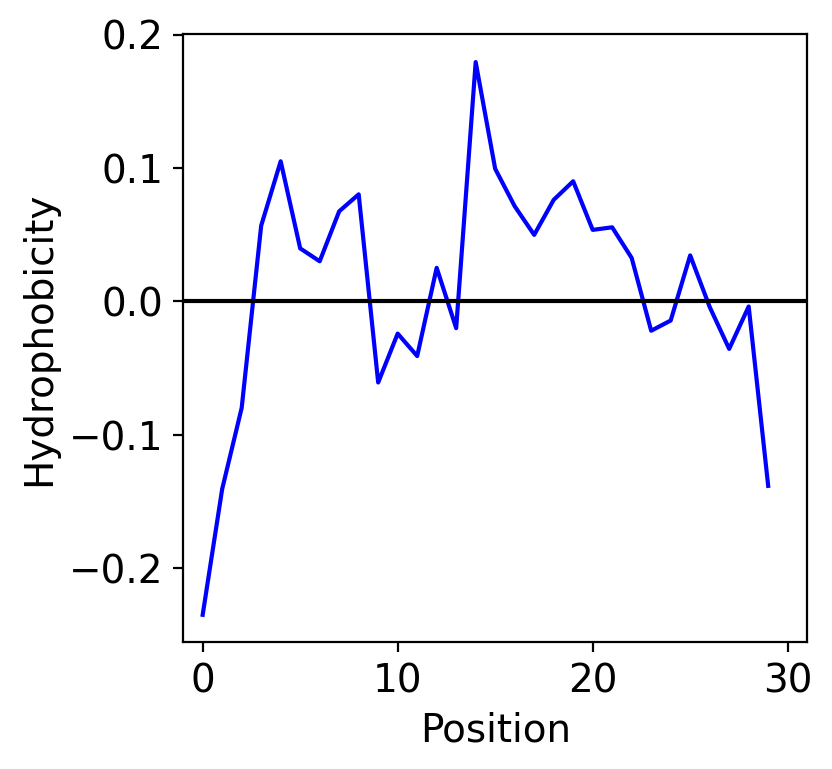

In [74]:
# there is agreement across the top differentials to select for two position specific hydrophobic patches
# for the most significant one check the pvalue and distribution
best = '87'
xs = row_colors['Binder'].map({'b':'Binder', 'lightgray':'Non-binder'})
ys = plot[int(best)]
fig, ax = plt.subplots(figsize=[1.5, 3])
ax.grid(False)
sns.barplot(x=xs, y=ys, errorbar=('ci', 95), err_kws={'linewidth': 2}, capsize=0.3,
            saturation=1, palette=['b','lightgray'], edgecolor='k', errcolor='k', linewidth=2)
ax.set_xlim(-0.75, 1.75)
print(best, ss.mannwhitneyu(ys[xs == 'Binder'], ys[xs != 'Binder'])[1])

# weights that are most important for the given node
weights = pd.Series(model.layers[5].kernel.numpy()[:200, int(best)]).sort_values()

# plot the features
consider_value('hydrophobicity')